In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = depthwiseseparableconv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = depthwiseseparableconv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_3 = depthwiseseparableconv2DBatchNormRelu(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 3)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.maxpool2d(self.cbr_3(x))
        
        #全結合層
        x = self.sigmoid(self.fc_1(self.flatten(x)))
        x = self.fc_2(x)
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                             Output Shape              Param #
Model                                              [64, 3]                   --
├─depthwiseseparableconv2DBatchNormRelu: 1-1       [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                                 [64, 3, 32, 32]           84
│    └─BatchNorm2d: 2-2                            [64, 3, 32, 32]           6
│    └─ReLU: 2-3                                   [64, 3, 32, 32]           --
│    └─Conv2d: 2-4                                 [64, 16, 32, 32]          64
│    └─BatchNorm2d: 2-5                            [64, 16, 32, 32]          32
│    └─ReLU: 2-6                                   [64, 16, 32, 32]          --
│    └─Dropout2d: 2-7                              [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                                   [64, 16, 16, 16]          --
├─depthwiseseparableconv2DBatchNormRelu: 1-3       [64, 32, 16, 16]          --
│    └─Conv2d: 2-8                  

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  3.00it/s]


val Loss: 1.1722 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


train Loss: 1.2752 Acc: 0.4044


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.10it/s]


val Loss: 1.2334 Acc: 0.3333
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 1.0356 Acc: 0.4575


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.08it/s]


val Loss: 1.3015 Acc: 0.3333
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


train Loss: 0.9769 Acc: 0.5065


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 1.2515 Acc: 0.3105
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.9484 Acc: 0.5485


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.95it/s]


val Loss: 1.0335 Acc: 0.5271
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.9144 Acc: 0.5846


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]


val Loss: 0.8443 Acc: 0.6319
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.8564 Acc: 0.6136


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.86it/s]


val Loss: 0.9109 Acc: 0.5538
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


train Loss: 0.8445 Acc: 0.6246


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]


val Loss: 1.4478 Acc: 0.4695
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.8042 Acc: 0.6527


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.89it/s]


val Loss: 0.8921 Acc: 0.6267
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.8093 Acc: 0.6416


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.91it/s]


val Loss: 0.8945 Acc: 0.6243
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.7675 Acc: 0.6657


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]


val Loss: 0.8260 Acc: 0.6462
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.7507 Acc: 0.6727


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 0.8083 Acc: 0.6233
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.7316 Acc: 0.6897


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]


val Loss: 0.7752 Acc: 0.6652
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


train Loss: 0.7036 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 0.8766 Acc: 0.6210
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.7213 Acc: 0.6997


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.9102 Acc: 0.6157
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.7253 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.8502 Acc: 0.6633
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.6754 Acc: 0.7177


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.88it/s]


val Loss: 0.8669 Acc: 0.6410
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.6487 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.88it/s]


val Loss: 0.8410 Acc: 0.6605
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.6608 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 0.7960 Acc: 0.6838
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


train Loss: 0.6450 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.97it/s]


val Loss: 0.9125 Acc: 0.5919
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.6556 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.91it/s]


val Loss: 0.9727 Acc: 0.5138
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.6215 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.59it/s]


val Loss: 0.8284 Acc: 0.6800
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.6084 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.78it/s]


val Loss: 0.9291 Acc: 0.6519
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


train Loss: 0.5955 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.98it/s]


val Loss: 0.8297 Acc: 0.6738
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.6085 Acc: 0.7457


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.87it/s]


val Loss: 0.8186 Acc: 0.6814
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.5758 Acc: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.8061 Acc: 0.6533
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.5457 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.9410 Acc: 0.5962
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.5577 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.76it/s]


val Loss: 0.8557 Acc: 0.6657
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


train Loss: 0.5584 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 1.0554 Acc: 0.6443
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.5633 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.97it/s]


val Loss: 0.8760 Acc: 0.6933
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


train Loss: 0.5742 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.7901 Acc: 0.6995
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.5053 Acc: 0.7978


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.95it/s]


val Loss: 0.8522 Acc: 0.6805
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.4977 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.88it/s]


val Loss: 0.8259 Acc: 0.6795
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.5088 Acc: 0.7978


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.90it/s]


val Loss: 0.8424 Acc: 0.6486
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


train Loss: 0.4901 Acc: 0.8028


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.7628 Acc: 0.7181
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.4518 Acc: 0.8158


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.89it/s]


val Loss: 1.2083 Acc: 0.5590
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 0.4846 Acc: 0.8198


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.39it/s]


val Loss: 0.7983 Acc: 0.7052
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


train Loss: 0.4663 Acc: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.78it/s]


val Loss: 0.9764 Acc: 0.6719
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.4117 Acc: 0.8328


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.79it/s]


val Loss: 1.0203 Acc: 0.6219
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.4229 Acc: 0.8138


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.79it/s]


val Loss: 0.9590 Acc: 0.6652
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.4186 Acc: 0.8328


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.7851 Acc: 0.7114
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.4316 Acc: 0.8208


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 1.2870 Acc: 0.6395
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.4221 Acc: 0.8228


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.8245 Acc: 0.7329
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.4445 Acc: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.68it/s]


val Loss: 1.1400 Acc: 0.5776
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.4272 Acc: 0.8288


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.81it/s]


val Loss: 0.8061 Acc: 0.7157
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.3423 Acc: 0.8679


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.9523 Acc: 0.7081
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


train Loss: 0.3702 Acc: 0.8498


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.81it/s]


val Loss: 1.7591 Acc: 0.4743
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


train Loss: 0.4163 Acc: 0.8288


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.81it/s]


val Loss: 1.0447 Acc: 0.6500
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.3701 Acc: 0.8549


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.77it/s]


val Loss: 0.9356 Acc: 0.7095
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.3751 Acc: 0.8438


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]

val Loss: 0.8334 Acc: 0.7338


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

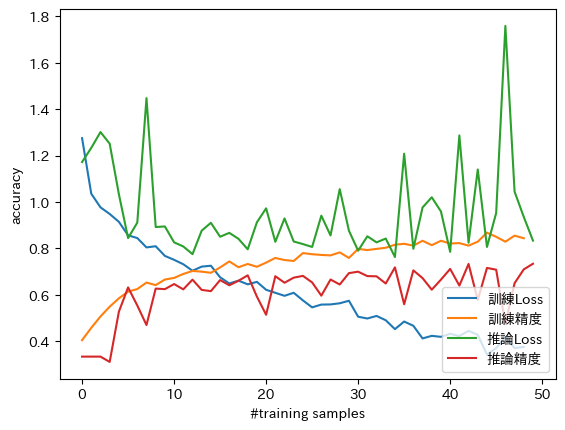

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

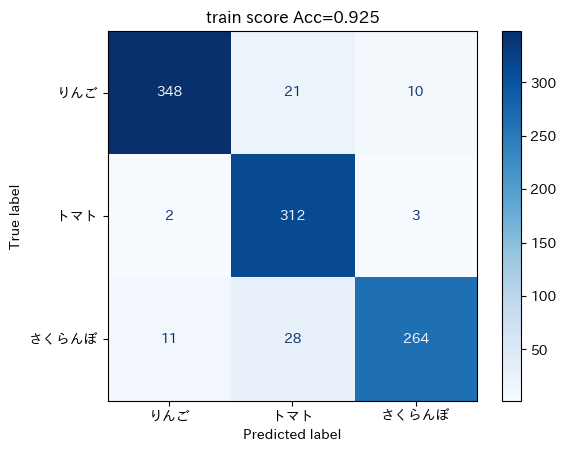

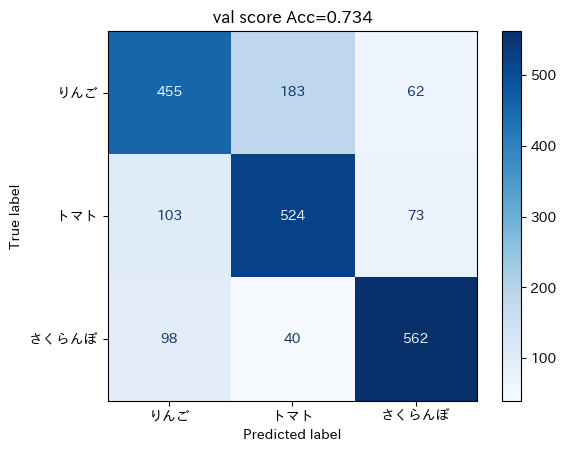

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

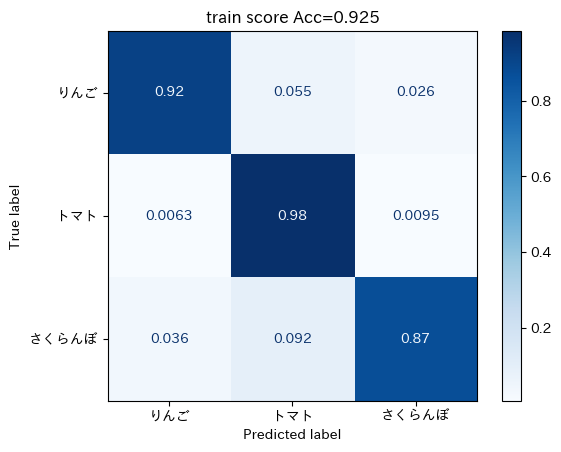

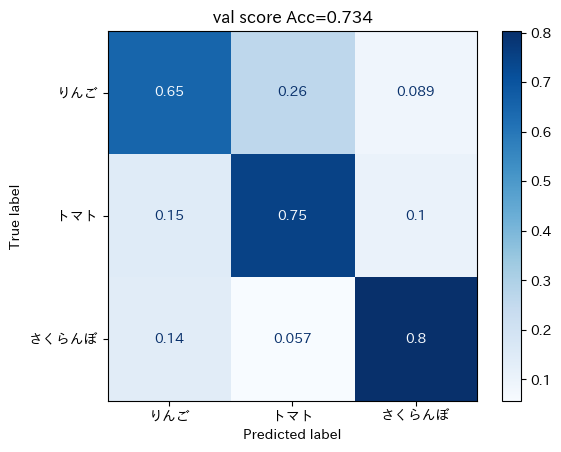

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()